## FEP calculations of relative binding affinity using Amber software

_Majda Misini Ignjatovic, PhD student_  
_Division of Theoretical Chemistry, Lund University_  
_January 2019_
  
  


The purpose of this Jupyter Notebook is to show the reader how to setup and perform analysis of Free Energy Perturbation (FEP) calculations of relative binding affinity, using AMBER software.  


### Software requirements

- Python2.7
    - matplotlib
    - numpy
    - pytraj
- Amber16 (This is needed if you want to run the calculations. Not needed for this notebook to work, since all the output files from Amber will be provided.)

### Python Module Imports

In [101]:
import os
import os.path
import sys
import math 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pytraj as pt
from math  import sqrt
from IPython.display import Image
from IPython.display import IFrame
from IPython.core.display import HTML

### Free energy calculations of relative binding affinity

The difference in binding affinity between two structurally similar ligands binding to a specific protein (**Figure 1.**), can be calculated using the so-called *Alchemical* free energy calculations. These calculations employ unphysical (alchemical) intermediates in order to estimate free energies of various physical processes. Some examples of these calculations are: free energy of transfer of a small molecule from gas to water (Free energy of solvation), absolute binding free energy of a ligand binding to a protein, free energy of a mutation of a protein side chain, or a mutation of a ligand bound to a protein (Relative binding affinity).

<table><tr>
<td> <img src="figures/prot-lig.png" alt="Drawing" style="width: 500px;"/> </td> 
<td> <img src="figures/l02.png" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="figures/l01.png" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>

**Figure 1.** Left: Protein–ligand binding example: a small ligand molecule binding to a large protein (P38 mitogen-activated protein kinase). Right: Ligands for which we calculate relative binding affinity. Difference between the two ligands is in the H– and F–atoms indicated in the two figures.

This Jupyter Notebook will focus on the **setup** and **analysis** of the calculations of the relative binding affinity, in which a ligand bound to a protein is mutated to another ligand.    

Every free energy calculation is based on a thermodynamic cycle, that defines the end-states of a simulation. For the calculations of relative binding affinity, the end-states are shown in the **Figure 2.** below. 

<img src="http://www.alchemistry.org/wiki/images/e/ec/Bind_example.png" alt="drawing" width="500"/>

**Figure 2.** Thermodynamic cycle used for the calculations of relative binding affinity *(the figure was taken from [this](http://www.alchemistry.org/wiki/Thermodynamic_Cycle) web page)*. 

As it can be seen from **Figure 2**, if we want to calculate relative binding affinity of two ligands (A and B) binding to a specific protein, we do not have to calculate the absolute binding affinities for each of the two ligands explicitly (horizontal arrows). Instead, the difference in binding will correspond to the difference in free energy of mutating ligand A to ligand B when they are bound to the protein, and free in solution (vertical arrows). This is shown in the equations below.

NVT ensemble: $$ΔΔA_{bind} = ΔA_{bind}^{B} - ΔA_{bind}^{A} = ΔA_{A→B}^{bound} - ΔA_{A→B}^{unbound}$$

NPT ensemble: $$ΔΔG_{bind} = ΔG_{bind}^{B} - ΔG_{bind}^{A} = ΔG_{A→B}^{bound} - ΔG_{A→B}^{unbound}$$

These calculations are much less demanding. Of course, the absolute binding affinities in that case do remain unfamiliar. However, for the purpose of drug design, one is interested mainly in the difference in binding between two ligands, that tells us which ligand is the stronger binder.

For each of the two systems, ligands bound to the protein and ligands free in solution, we will simulate mutation of ligand A to ligand B. This means that the end-states for the first system, where ligands are bound to the protein, will be a system where only ligand A is bound to the protein, and a system where only ligand B is bound to the protein. When ligands are free in solution, the end-states will be a system where only ligand A is present in solution, and a system where only ligand B is present in solution. 

Each end-state has a defined potential, $U_{A}$ or $U_{B}$. To simulate the transformation of ligand A to ligand B, we can introduce intermediate states, for which the potential $U$ is the sum of the alchemically modified two end-states potentials $U_{A}$ and $U_{B}$. This is done by introducing a coupling parameter λ, that can have values from 0 to 1. Then, the modified potential is calculated as: $$U(λ) = (1-λ)U_{A} + λU_{B}$$

When λ = 0, we simulate only the state A. By running the simulations using different modified potentials (gradually increasing the λ values), we alchemically transform ligand A to ligand B. At λ = 1, ligand A is completely transformed into ligand B. Here, we will use **13 λ values**.

Finally, to estimate the free energy of mutating ligand A to ligand B, the simplest way is to use Thermodynamic Integration (TI) method. $$\Delta G= \int_{0}^{1}\left \langle \partial U/\partial \lambda  \right \rangle _{\lambda } d\lambda $$

TI method will be used in this notebook. However, there are other methods that can be used to estimate free energy, such as exponential averaging, Bennett acceptance ratio method (BAR), Multistate Bennett Acceptance Ratio method (MBAR).

### 1 Setup

It is assumed that the parameter file and the coordinate file already exist for both, ligands bound to the protein (prefix *prot*) and ligands free in solution (prefix *wat*). We do not need to perform calculations in which protein is free in solution, since those are the same for both protein–ligand systems.

These files are provided:
    - prot.prm (parameter file for the protein–ligands–water system)
    - prot.rst (coordinate file for the protein–ligands–water system)
    - wat.prm (parameter file for the ligands–water system)
    - wat.rst (coordinate file for the ligands–water system)  

**Figure 3.** shows the simulated protein–ligands–water and ligands–water systems. **Enclosed files do not contain any water, in order to save memory.**

<table><tr>
<td> <img src="figures/bound.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="figures/free.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

**Figure 3.** Systems used in simulations. Left: protein–ligands–water (bound). Right: ligands–water (free).

#### 1.1 Create sander input files

We want to perform a total of 26 simulations, for 2 systems (protein–ligands–water and ligands–water) with 13 λ values (0.00, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, and 1.00). Each of the 26 simulations has four steps: 

- Minimization
- NVT equilibration
- NPT equilibration
- NPT production (Here we collect coordinate snapshots and energies)

This means we have to generate a total of 104 (26x4) **input files for sander**, the Amber module which carries out energy minimization, molecular dynamics, and NMR refinements. Executing the cells below will generate these files.

First, we define the names of the ligands A and B, as well as the list of the unique atoms in these ligands that do not appear in the opposite ligand. The ligand names should correspond to the residue names these ligands have in the parameter files. The unique atoms should also have the same name as in the parameter files, and should be separated by a comma. These are needed for the input files and are supposed to be changed if you intend to create input for different protein–ligand systems.

In [2]:
ligand_A="L02" # Residue name of ligand A.
ligand_B="L01" # Residue name of ligand B.
unique_atoms_A="F72" # Unique atoms in ligand A.
unique_atoms_B="H72" # Unique atoms in ligand B.

Then, we create a directory named *AtoB* in which we will run the simulations. Make sure you have a copy of the parameter files and the starting coordinate files in this directory before running the simulations, or provide the correct path to these files when starting the simulations. In this directory we will then generate the sander input files. 

In [3]:
%%bash -s "$ligand_A" "$ligand_B" "$unique_atoms_A" "$unique_atoms_B"

# Please check the Amber manual for detailed explanation of the simulation parameters used below.

mkdir $1to$2 # This will create a directory named AtoB, or L02toL01 in this case. 
cd $1to$2 

# The two for loops below will generate the 104 input files for sander, that can be found in the AtoB directory.
for X in "0.00" "0.05" "0.10" "0.20" "0.30" "0.40" "0.50" "0.60" "0.70" "0.80" "0.90" "0.95" "1.00" 
do

for Y in "prot" "wat"
do

# Input files for minimization.
cat <<EOF > ${Y}-sander-${X}.in1
TI 1 Minimization, lambda=${X}
 &cntrl
  irest=0,ntx=1,
  imin=1,maxcyc=500,drms=0.0001,ntmin=2,
  ntc=2,ntf=1,
  cut=8.0,
  ntpr=100,ntwx=0,ntwv=0,ntwe=0,
  ntr=1,restraint_wt=100,
  restraintmask="!:WA= & !@H=",
  icfe=1,clambda=${X},ifsc=1,
  timask1=":$1",scmask1=":$1@$3",
  timask2=":$2",scmask2=":$2@$4",
 &end
EOF

# Input files for NVT equilibration.
cat <<EOF > ${Y}-sander-${X}.in2
TI 2 NVT, lambda=${X}
 &cntrl
  irest=0,ntx=1,
  nstlim=10000,dt=0.002,
  ntb=1,temp0=300.0,ntt=3,gamma_ln=2.0,
  ntc=2,ntf=1,
  cut=8.0,
  ntpr=5000,ntwx=0,ntwv=0,ntwe=0,
  ntr=1,restraint_wt=100,
  restraintmask="!:WA= & !@H=",
  icfe=1,clambda=${X},ifsc=1,
  timask1=":$1",scmask1=":$1@$3",
  timask2=":$2",scmask2=":$2@$4",
 &end
EOF

# Input files for NPT equilibration.
cat <<EOF > ${Y}-sander-${X}.in3
TI 3 NPT equilibration, lambda=${X}
 &cntrl
  irest=1,ntx=5,
  nstlim=250000,dt=0.002,
  ntb=2,temp0=300.0,ntt=3,gamma_ln=2.0,
  ntc=2,ntf=1,
  cut=8.0,
  ntp=1,pres0=1.0,taup=1.0,
  ntpr=5000,ntwx=0,ntwv=0,ntwe=0,
  icfe=1,clambda=${X},ifsc=1,
  timask1=":$1",scmask1=":$1@$3",
  timask2=":$2",scmask2=":$2@$4",
 &end
EOF

# Input files for NPT production.
cat <<EOF > ${Y}-sander-${X}.in4
TI 4 NPT production, lambda=${X}
 &cntrl
  irest=1,ntx=5,
  nstlim=500000,dt=0.002,
  ntb=2,temp0=300.0,ntt=3,gamma_ln=2.0,
  ntc=2,ntf=1,
  cut=8.0,
  ntp=1,pres0=1.0,taup=1.0,
  ntpr=500,ntwx=500,ntwv=0,ntwe=0,
  icfe=1,clambda=${X},ifsc=1,
  timask1=":$1",scmask1=":$1@$3",
  timask2=":$2",scmask2=":$2@$4",
  ifmbar=1,bar_intervall=500,bar_l_min=0.00,bar_l_max=1.00,bar_l_incr=0.05,
 &end
EOF

done

done

cd ..

echo "Done. You will find the files in the $1to$2 directory."

Done. You will find the files in the L02toL01 directory.


#### 1.2 Create job description files

These simulations can be run in parallel on a supercomputer such is [Aurora](http://www.lunarc.lu.se/resources/hardware/aurora/). Once you login to Aurora, you can register your program with SLURM for execution using the *sbatch* command. This is done easiest by using a **job description file**. To submit a job you need to execute: 

    sbatch job_description_file 

To run the 26 simulations, we will need 26 job description files. Executing the cell below will generate these files, as well as an additional *bash* script contatining *sbatch* commands for all 26 simulations – *submit_all.bash*. To submit all 26 simulations at once, simply execute:  

    bash submit_all.bash

In [4]:
%%bash -s "$ligand_A" "$ligand_B"

cd $1to$2

for X in "0.00" "0.05" "0.10" "0.20" "0.30" "0.40" "0.50" "0.60" "0.70" "0.80" "0.90" "0.95" "1.00" 
do

for Y in "prot" "wat"
do

cat <<EOF > q-${Y}-${X}
#SBATCH -N 1
#SBATCH -n 20
#SBATCH -A --exclusive
#SBATCH -t 168:00:00

module purge
module load ifort/2017.4.196-GCC-6.4.0-2.28 impi/2017.3.196 Amber/16-AmberTools-17-patchlevel-0-7

cd $SLURM_SUBMIT_DIR
mpirun -bind-to core -np 20 pmemd.MPI -O -i ${Y}-sander-${X}.in1 -o ${Y}-sander-${X}.out1 -p ${Y}.prm -c ${Y}.rst          -r ${Y}-${X}.mdrest1 -ref ${Y}.rst
mpirun -bind-to core -np 20 pmemd.MPI -O -i ${Y}-sander-${X}.in2 -o ${Y}-sander-${X}.out2 -p ${Y}.prm -c ${Y}-${X}.mdrest1 -r ${Y}-${X}.mdrest2 -ref ${Y}.rst
mpirun -bind-to core -np 20 pmemd.MPI -O -i ${Y}-sander-${X}.in3 -o ${Y}-sander-${X}.out3 -p ${Y}.prm -c ${Y}-${X}.mdrest2 -r ${Y}-${X}.mdrest3
mpirun -bind-to core -np 20 pmemd.MPI -O -i ${Y}-sander-${X}.in4 -o ${Y}-sander-${X}.out4 -p ${Y}.prm -c ${Y}-${X}.mdrest3 -r ${Y}-${X}.mdrest4 -x ${Y}-${X}.mdcrd4
EOF

cat <<EOF >> submit_all.bash  
sbatch q-${Y}-${X}
EOF

done

done

cd ..

echo "Done. You will find the files in the $1to$2 directory."

Done. You will find the files in the L02toL01 directory.


### 2 Analysis

After running the 26 simulations, you will have a number of files:
    - *sander.out* - sander output files (4 for each simulation)
    - *mdrest* - restart files (4 for each simulation)
    - *mdcrd* - trajectory files *mdcrd* (1 for each simulation)
(234 new files in total)



#### 2.1 Plotting RMSD as a function of simulation time

The most basic type of analysis performed after MD simulations is coordinate root mean square deviation (RMSD) analysis. RMSD measures the deviation of a target set of coordinates to a reference set of coordinates, with RMSD=0 indicating a perfect overlap. Executing the cells below will calculate and plot RMSD values as a function of simulation time for all 13 trajectories in which the ligands are bound to the protein. RMSD will be calculated based on the CA atoms of the protein backbone. 

In [116]:
%%bash

cd data 

for X in 0.00 0.05 0.10 0.20 0.30 0.40 0.50 0.60 0.70 0.80 0.90 0.95 1.00; do gzip -d prot-${X}.mdcrd4.gz; done

cd -

echo "Done."

# This will decompress some of the files.

Done.


/Users/majdamisini/PhD_courses/Jupyter/Project/data


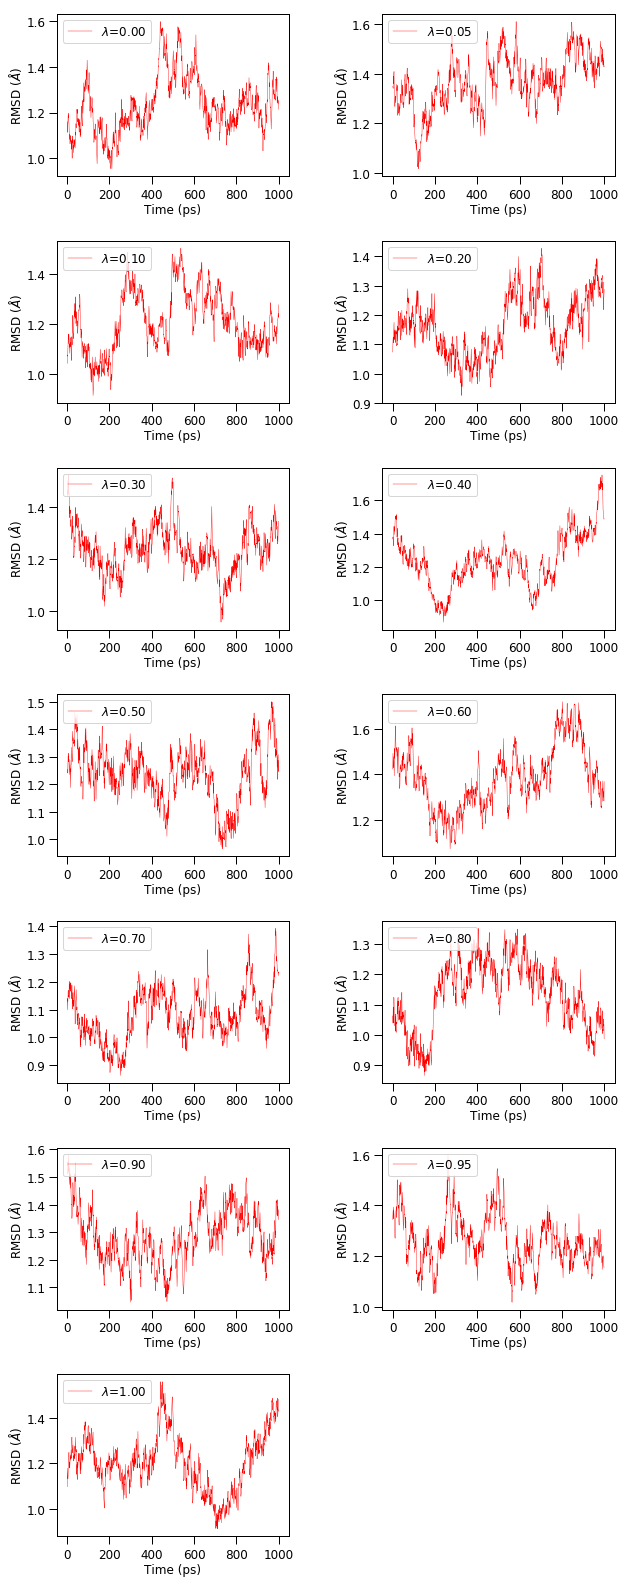

/Users/majdamisini/PhD_courses/Jupyter/Project


In [117]:
%cd data

### Time(ps)

time = []    
nstlim=500000  # This number corresponds to the number in the *sander.in4 files.
dt=0.002       # This number corresponds to the number in the *sander.in4 files.
ntwx=500       # This number corresponds to the number in the *sander.in4 files.
number_of_frames=nstlim/ntwx
sampling_freq=ntwx*dt
curr_time=0
for X in range (0,number_of_frames):
    curr_time=curr_time+sampling_freq
    time.append(curr_time) 
    
### RMSD (Angstrom)

lambdas=["0.00","0.05","0.10","0.20","0.30","0.40","0.50","0.60","0.70","0.80","0.90","0.95","1.00"]
rmsd_prots = {}
 
plt.rcParams.update({'figure.figsize': [10.0, 4.0*int(float(len(lambdas)+1)/2.0)],
                     'font.size': 12,
                     'xtick.major.width': 1.0, 
                     'ytick.major.width': 1.0, 
                     'axes.labelsize': 12, 
                     'axes.linewidth': 1.0, 
                     'axes.labelpad': 2,
                     'xtick.labelsize': 12, 
                     'ytick.labelsize': 12,  
                     'xtick.major.size': 8, 
                     'ytick.major.size': 8 ,
                     'legend.fontsize': 10})
fig = plt.figure()
fig.subplots_adjust(wspace = 0.4, hspace = 0.4)

for element in lambdas:
    
    # Reading prot trajectories and calculating rmsd
    trajProt = pt.load("prot-{0}.mdcrd4".format(element), "prot.prm")
    referenceProt = pt.load("prot.rst", "prot.prm")
    rmsd_prots['rmsd_prot_{0}'.format(element)] = pt.rmsd(trajProt, mask=['@CA'], ref=referenceProt)
    
    # Plotting prot rmsd
    sp = fig.add_subplot(int(float(len(lambdas)+1)/2.0), 2, lambdas.index(element)+1)
    sp.plot(time, rmsd_prots['rmsd_prot_{0}'.format(element)],
            color='r',ls='solid',linewidth=0.4,label='$\lambda$=''{0}'.format(element))
    sp.set_xlabel("Time (ps)")
    sp.set_ylabel("RMSD ($\AA$)")
    sp.legend(loc='upper left',fontsize=12)
    
plt.show()
fig.savefig("./rmsd_figure_all.png",dpi=300)

%cd -

#### 2.2 Plotting dU/dλ as a function of simulation time

Executing the cell below will plot $\frac{\partial U}{\partial \lambda }$ as a function of simulation time for 13 λ values for the **protein–ligads–water** system.

[Errno 2] No such file or directory: 'data'
/Users/majdamisini/PhD_courses/Jupyter/Project/data


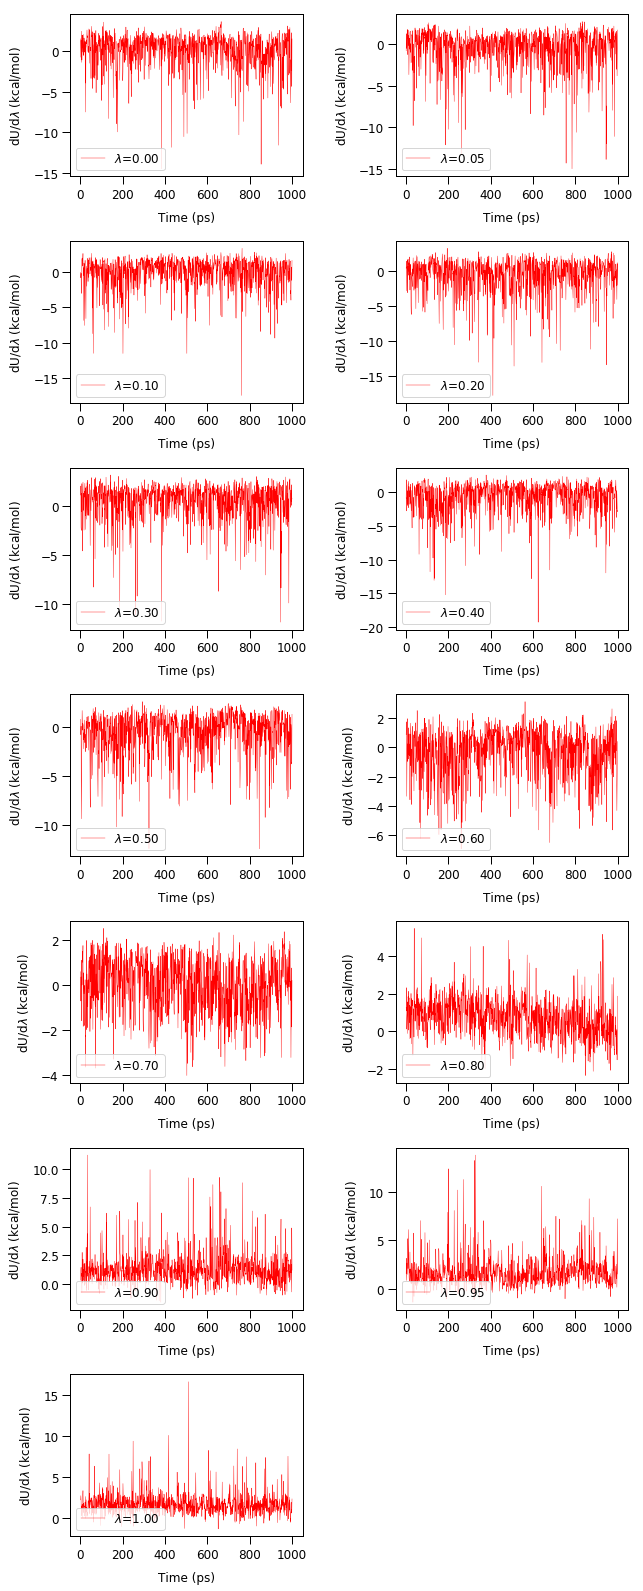

/Users/majdamisini/PhD_courses/Jupyter/Project


In [106]:
% cd data
    
lambdas=["0.00","0.05","0.10","0.20","0.30","0.40","0.50","0.60","0.70","0.80","0.90","0.95","1.00"]
dVdL_prots = {}
plt.rcParams.update({'figure.figsize': [10.0, 4.0*int(float(len(lambdas)+1)/2.0)],
                     'font.size': 12,
                     'xtick.major.width': 1.0, 
                     'ytick.major.width': 1.0, 
                     'axes.labelsize': 12, 
                     'axes.linewidth': 1.0, 
                     'axes.labelpad': 10,
                     'xtick.labelsize': 12, 
                     'ytick.labelsize': 12,  
                     'xtick.major.size': 8, 
                     'ytick.major.size': 8 ,
                     'legend.fontsize': 10})
fig = plt.figure()
fig.subplots_adjust(wspace = 0.4, hspace = 0.4)

for element in lambdas:
    dVdL = []
    f = open("prot-{0}-sander.out4".format(element))
    for line in f:
        fields = line.strip().split()
        if len(fields) == 3: 
            if fields[0] == "DV/DL" :
                dVdL.append(fields[2])
    dVdL = dVdL[::2] # Remove every second element from the list.
    dVdL = dVdL[:-3] # Remove the last three members of the list.
    dVdL_prots['dVdL_prot_{0}'.format(element)] = dVdL
    
### Plotting

    sp = fig.add_subplot(int(float(len(lambdas)+1)/2.0), 2, lambdas.index(element)+1)
    sp.plot(time, dVdL_prots['dVdL_prot_{0}'.format(element)],
           color='r',ls='solid',linewidth=0.4,label='$\lambda$=''{0}'.format(element))
    sp.set_xlabel("Time (ps)")
    sp.set_ylabel("dU/d$\lambda$ (kcal/mol)") # The λ character cannot be easily printed. 
    sp.legend(loc='lower left',fontsize=12)
    
plt.show()
fig.savefig("./dUdLambda_figure_prot.png")

% cd -

Executing the cell below will plot $\frac{\partial U}{\partial \lambda }$ as a function of simulation time for 13 λ values for the **ligads–water** system.

/Users/majdamisini/PhD_courses/Jupyter/Project/data


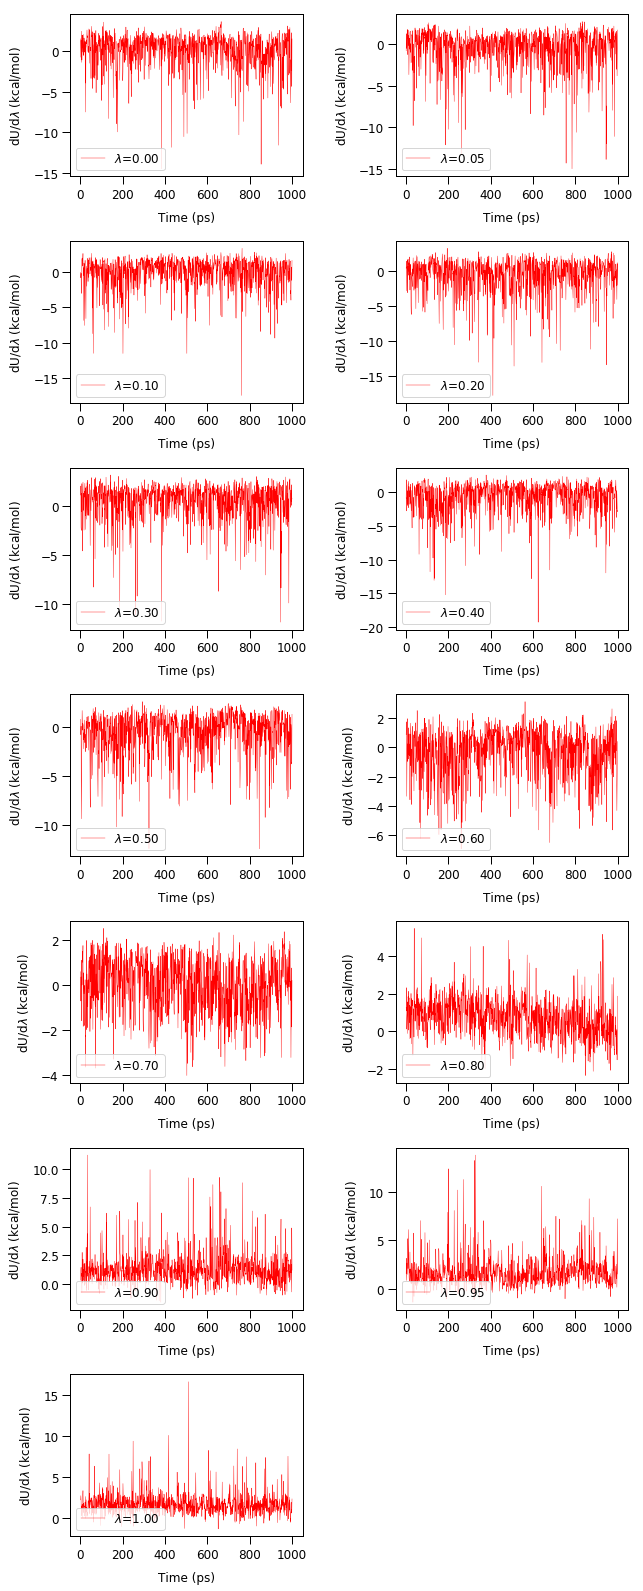

/Users/majdamisini/PhD_courses/Jupyter/Project


In [107]:
% cd data

dVdL_wats = {}
plt.rcParams.update({'figure.figsize': [10.0, 4.0*int(float(len(lambdas)+1)/2.0)],
                     'font.size': 12,
                     'xtick.major.width': 1.0, 
                     'ytick.major.width': 1.0, 
                     'axes.labelsize': 12, 
                     'axes.linewidth': 1.0, 
                     'axes.labelpad': 10,
                     'xtick.labelsize': 12, 
                     'ytick.labelsize': 12,  
                     'xtick.major.size': 8, 
                     'ytick.major.size': 8 ,
                     'legend.fontsize': 10})
fig = plt.figure()
fig.subplots_adjust(wspace = 0.4, hspace = 0.4)

for element in lambdas:
    dVdL = []
    f = open("wat-{0}-sander.out4".format(element))
    for line in f:
        fields = line.strip().split()
        if len(fields) == 3: 
            if fields[0] == "DV/DL" :
                dVdL.append(fields[2])
    dVdL = dVdL[::2] # Remove every second element from the list.
    dVdL = dVdL[:-3] # Remove the last three members of the list.
    dVdL_wats['dVdL_wat_{0}'.format(element)] = dVdL
    
### Plotting

    sp = fig.add_subplot(int(float(len(lambdas)+1)/2.0), 2, lambdas.index(element)+1)
    sp.plot(time, dVdL_prots['dVdL_prot_{0}'.format(element)],
           color='r',ls='solid',linewidth=0.4,label='$\lambda$=''{0}'.format(element))
    sp.set_xlabel("Time (ps)")
    sp.set_ylabel("dU/d$\lambda$ (kcal/mol)") # The λ character cannot be easily printed. 
    sp.legend(loc='lower left',fontsize=12)
    
plt.show()
fig.savefig("./dUdLambda_figure_wat.png")

% cd -

#### 2.3 Calculating free energies with TI

In order to calculate free energies, we have to extract data from the output files. Executing the cell below will extract average $\partial U/\partial \lambda$ from simulation output files.

In [125]:
% cd data

def read_average(fileprefix,fn):

### get average and rms values of DV/DL

    average_dvdl=[];
    rms_dvdl=[];
    
    for element in lambdas:
        file = fileprefix + "-" + str(element) +"-sander.out4";
        file1 = open(file, 'r'); 

        flag_average = 0;
        flag_rms     = 0;
        lines  =  file1.readlines();
        num_lines = len(lines);

        for line in lines:
            linesplit = line.split() 
            if (len(linesplit) > 2):
                if (linesplit[0] == "A" and linesplit[1] == "V"):
                    flag_average = 1;
                    flag_rms     = 0;

                if (linesplit[0] == "R" and linesplit[1] == "M"):
                    flag_average = 0;
                    flag_rms     = 1;

                if (flag_average == 1 and linesplit[0] == "DV/DL"):
                    average_dvdl.append( float(linesplit[2]) );

                if (flag_rms == 1 and linesplit[0] == "DV/DL"):
                    rms_dvdl.append( float(linesplit[2]) );
                    flag_rms = 0; 
                    
        file1.close();
        
    average_dvdl = average_dvdl[::2]
    rms_dvdl = rms_dvdl[::2]
    
    return average_dvdl,rms_dvdl;
#################################################################################################################
def write_average(average_dvdl,rms_dvdl,file):
    float_lambdas=[0.00,0.05,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,0.95,1.00]
    fn = len(average_dvdl);
    file.write("Lambda  DU/DL    rms   "+"\n");
    for i in range(1,fn+1):
        file.write( "%.3f  %.5f  %2f" %(float_lambdas[i-1],average_dvdl[i-1],rms_dvdl[i-1]) ) ;
        file.write( "\n" );
    return;
#################################################################################################################
def main():
    
    fileprefix=["prot","wat"]
    for el in fileprefix:
        num=13;
        average_dvdl,rms_dvdl = read_average( el, num );
        file_report = "report." + el;
        file = open( file_report, 'write' );
        write_average(average_dvdl,rms_dvdl,file); 
        file.close()
        print("Printed file report."+el+".")
    
#################################################################################################################
#################################################################################################################
main()

% cd -

print("Done.")

/Users/majdamisini/PhD_courses/Jupyter/Project/data
Printed file report.prot.
Printed file report.wat.
/Users/majdamisini/PhD_courses/Jupyter/Project
Done.


Plot average $\partial U/\partial \lambda$ for protein–ligands–water system (bound system).

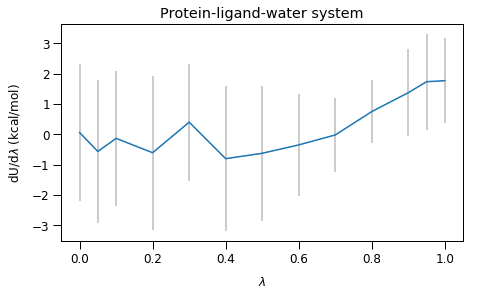

In [109]:
x_arr=np.loadtxt('data/report.prot',skiprows=1,usecols=(0))
y_arr=np.loadtxt('data/report.prot',skiprows=1,usecols=(1))
y_err=np.loadtxt('data/report.prot',skiprows=1,usecols=(2))
plt.rcParams.update({'figure.figsize': [7.2, 4.0],
                     'font.size': 12,
                     'xtick.major.width': 1.0, 
                     'ytick.major.width': 1.0, 
                     'axes.labelsize': 12, 
                     'axes.linewidth': 1.0, 
                     'axes.labelpad': 10,
                     'xtick.labelsize': 12, 
                     'ytick.labelsize': 12,  
                     'xtick.major.size': 8, 
                     'ytick.major.size': 8 ,
                     'legend.fontsize': 10})
fig = plt.figure()
sp = fig.add_subplot(1,1,1)
sp.plot(x_arr,y_arr)
sp.errorbar(x_arr,y_arr,y_err,ls='solid',linewidth=0.4,ecolor="black")
sp.set_xlabel("$\lambda$")
sp.set_ylabel("dU/d$\lambda$ (kcal/mol)")
sp.set_title("Protein-ligand-water system", loc='center')
plt.show()
fig.savefig("./average_dUdLambda_prot.png", dpi=300)

Plot average $\partial U/\partial \lambda$ for ligands–water system (free system).

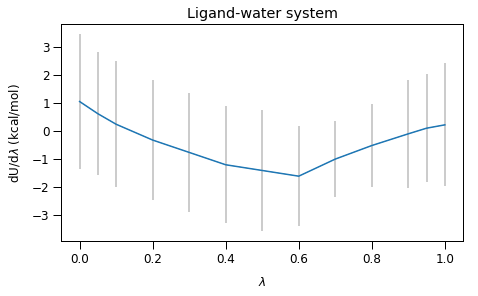

In [110]:
x_arr=np.loadtxt('data/report.wat',skiprows=1,usecols=(0))
y_arr=np.loadtxt('data/report.wat',skiprows=1,usecols=(1))
y_err=np.loadtxt('data/report.wat',skiprows=1,usecols=(2))
plt.rcParams.update({'figure.figsize': [7.2, 4.0],
                     'font.size': 12,
                     'xtick.major.width': 1.0, 
                     'ytick.major.width': 1.0, 
                     'axes.labelsize': 12, 
                     'axes.linewidth': 1.0, 
                     'axes.labelpad': 10,
                     'xtick.labelsize': 12, 
                     'ytick.labelsize': 12,  
                     'xtick.major.size': 8, 
                     'ytick.major.size': 8 ,
                     'legend.fontsize': 10})
fig = plt.figure()
sp = fig.add_subplot(1,1,1)
sp.plot(x_arr,y_arr)
sp.errorbar(x_arr,y_arr,y_err,ls='solid',linewidth=0.4,ecolor="black")
sp.set_xlabel("$\lambda$")
sp.set_ylabel("dU/d$\lambda$ (kcal/mol)")
sp.set_title("Ligand-water system", loc='center')
plt.show()
fig.savefig("./average_dUdLambda_wat.png", dpi=300)

TI integration with numpy

In [124]:
x_arr=np.loadtxt('data/report.prot',skiprows=1,usecols=(0))
y_arr=np.loadtxt('data/report.prot',skiprows=1,usecols=(1))
dGprot=np.trapz(y_arr,x=x_arr) # Integration
print("Free energy of mutation of ligand A to ligand B in protein–water environment (bound ligands): "+str(dGprot)+" kcal/mol." )

Free energy of mutation of ligand A to ligand B in protein–water environment (bound ligands): 0.071205 kcal/mol.


In [123]:
x_arr=np.loadtxt('data/report.wat',skiprows=1,usecols=(0))
y_arr=np.loadtxt('data/report.wat',skiprows=1,usecols=(1))
dGwat=np.trapz(y_arr,x=x_arr) # Integration
print("Free energy of mutation of ligand A to ligand B in water environment (free ligands): "+str(dGwat)+" kcal/mol." )

Free energy of mutation of ligand A to ligand B in water environment (free ligands): -0.6074900000000001 kcal/mol.


Using the two $ΔG_{A→B}$, it is possible to calculate relative binding affinity ($ΔΔG_{bind}$) based on the thermodynamic cycle in **Figure 2.**
